In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Stats
from statsmodels.tsa.stattools import adfuller

# Data
import yfinance as yf

TICKERS = ["TCS.NS","INFY.NS","RELIANCE.NS","HDFCBANK.NS","ITC.NS"]

# ----- Date windows -----
# Stationarity & Z-score window
STAT_START = "2022-12-01"
STAT_END   = "2024-11-30"

# Sharpe window (daily, Dec 2023 – Nov 2024)
SHARPE_START = "2023-12-01"
SHARPE_END   = "2024-11-30"

# Golden/Death Cross window (Dec 2022 – Nov 2024)
CROSS_START = "2022-12-01"
CROSS_END   = "2024-11-30"

FOCUS_STOCK = TICKERS[0]

In [2]:
# Question 2 
# UTILITIES

def fetch_ohlc(ticker: str, start: str, end: str, interval: str = "1d") -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if not df.empty:
        df = df.rename(columns=str.title) 
    return df

def adf_stat(series: pd.Series) -> dict:
    s = pd.to_numeric(series, errors="coerce").dropna()
    stat, pval, usedlag, nobs, crit, icbest = adfuller(s)
    return {"stat": stat, "pvalue": pval, "usedlag": usedlag, "nobs": nobs, "crit": crit}

def zscore(x: pd.Series) -> pd.Series:
    x = pd.to_numeric(x, errors="coerce").dropna()
    return (x - x.mean()) / x.std(ddof=0)

def golden_death_cross_dates(close: pd.Series, short: int = 15, long: int = 50):
    c = pd.to_numeric(close, errors="coerce").dropna()
    ma_s = c.rolling(short).mean()
    ma_l = c.rolling(long).mean()
    golden = (ma_s.shift(1) < ma_l.shift(1)) & (ma_s >= ma_l)  
    death  = (ma_s.shift(1) > ma_l.shift(1)) & (ma_s <= ma_l)  
    return list(c.index[golden.fillna(False)]), list(c.index[death.fillna(False)])


In [4]:
# 2A) Stationarity Testing (ADF)

from itertools import combinations

def extract_close_series(df: pd.DataFrame) -> pd.Series:
    """
    Return a 1-D Close price Series from a yfinance DataFrame that may have
    single-level or MultiIndex columns. Returns empty Series if not found.
    """
    if df is None or df.empty:
        return pd.Series(dtype="float64")

    # If columns are MultiIndex 
    if isinstance(df.columns, pd.MultiIndex):
        # Try (field, ticker) style where first level is like 'Close'
        candidates = [col for col in df.columns if str(col[0]).strip().lower() == "close"]
        if candidates:
            s = df[candidates[0]]
            if isinstance(s, pd.DataFrame):
                # squeeze to 1-D if needed
                if s.shape[1] > 0:
                    s = s.iloc[:, 0]
            return pd.to_numeric(s, errors="coerce").dropna()

        # Try (ticker, field) style where second level is 'Close'
        candidates = [col for col in df.columns if str(col[-1]).strip().lower() == "close"]
        if candidates:
            s = df[candidates[0]]
            if isinstance(s, pd.DataFrame):
                if s.shape[1] > 0:
                    s = s.iloc[:, 0]
            return pd.to_numeric(s, errors="coerce").dropna()

        # As a fallback, flatten and take the first column that startswith 'close'
        flat = df.copy()
        flat.columns = ["_".join(map(str, c)).strip() for c in df.columns]
        for c in flat.columns:
            if str(c).strip().lower().startswith("close"):
                return pd.to_numeric(flat[c], errors="coerce").dropna()

        return pd.Series(dtype="float64")

    # Single-level columns: look for 'Close' (case-insensitive, tolerant of variants)
    col = None
    for c in df.columns:
        name = str(c).strip().lower()
        if name == "close" or name.startswith("close"):
            col = c
            break
    if col is None:
        return pd.Series(dtype="float64")

    s = df[col]
    if isinstance(s, pd.DataFrame):
        # squeeze to 1-D if somehow DataFrame
        if s.shape[1] > 0:
            s = s.iloc[:, 0]
    return pd.to_numeric(s, errors="coerce").dropna()


# ---- Build close_data dict robustly
close_data = {}
for tkr in TICKERS:
    df = fetch_ohlc(tkr, STAT_START, STAT_END)
    if df.empty:
        print(f"[WARN] No data for {tkr} in {STAT_START}–{STAT_END}")
        continue
    s = extract_close_series(df)
    if s.empty:
        print(f"[WARN] Could not extract a Close series for {tkr}. Columns: {list(df.columns)}")
        continue
    close_data[tkr] = s

# ---- ADF on ratio of closes for all pairs
results = []
for a, b in combinations(close_data.keys(), 2):
    ratio = (close_data[a] / close_data[b]).dropna()
    if ratio.empty:
        continue
    res = adf_stat(ratio)
    results.append({"pair": (a, b), "pvalue": res["pvalue"], "stat": res["stat"]})

adf_df = pd.DataFrame(results).sort_values("pvalue").reset_index(drop=True)
display(adf_df.head(10))
display(adf_df.tail(10))

STATIONARY_PAIR    = tuple(adf_df.iloc[0]["pair"]) if not adf_df.empty else None
NONSTATIONARY_PAIR = tuple(adf_df.iloc[-1]["pair"]) if not adf_df.empty else None

print("Stationary candidate:", STATIONARY_PAIR)
print("Non-stationary candidate:", NONSTATIONARY_PAIR)

,pair,pvalue,stat
0,"(INFY.NS, ITC.NS)",0.061522,-2.777754
1,"(HDFCBANK.NS, ITC.NS)",0.128741,-2.447633
2,"(TCS.NS, INFY.NS)",0.179359,-2.277405
3,"(RELIANCE.NS, ITC.NS)",0.180753,-2.273213
4,"(TCS.NS, ITC.NS)",0.213431,-2.180412
5,"(TCS.NS, RELIANCE.NS)",0.225453,-2.148531
6,"(TCS.NS, HDFCBANK.NS)",0.479352,-1.608441
7,"(INFY.NS, HDFCBANK.NS)",0.507430,-1.552438
8,"(INFY.NS, RELIANCE.NS)",0.696646,-1.145365
9,"(RELIANCE.NS, HDFCBANK.NS)",0.730775,-1.059953


,pair,pvalue,stat
0,"(INFY.NS, ITC.NS)",0.061522,-2.777754
1,"(HDFCBANK.NS, ITC.NS)",0.128741,-2.447633
2,"(TCS.NS, INFY.NS)",0.179359,-2.277405
3,"(RELIANCE.NS, ITC.NS)",0.180753,-2.273213
4,"(TCS.NS, ITC.NS)",0.213431,-2.180412
5,"(TCS.NS, RELIANCE.NS)",0.225453,-2.148531
6,"(TCS.NS, HDFCBANK.NS)",0.479352,-1.608441
7,"(INFY.NS, HDFCBANK.NS)",0.507430,-1.552438
8,"(INFY.NS, RELIANCE.NS)",0.696646,-1.145365
9,"(RELIANCE.NS, HDFCBANK.NS)",0.730775,-1.059953


Stationary candidate: ('INFY.NS', 'ITC.NS')
Non-stationary candidate: ('RELIANCE.NS', 'HDFCBANK.NS')


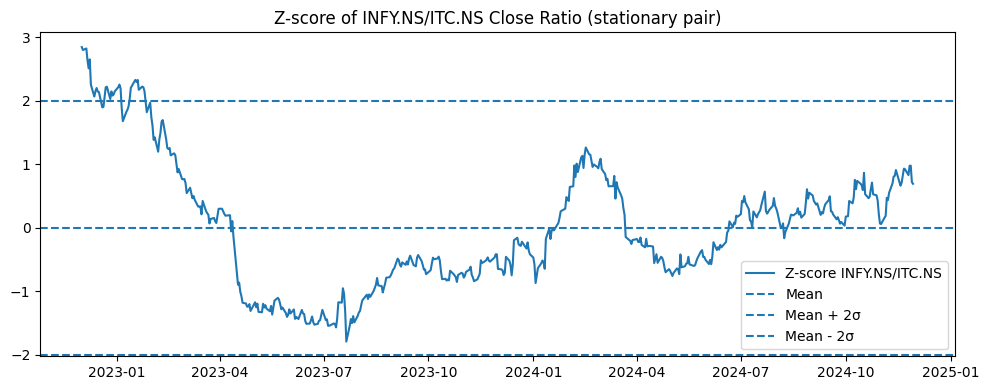

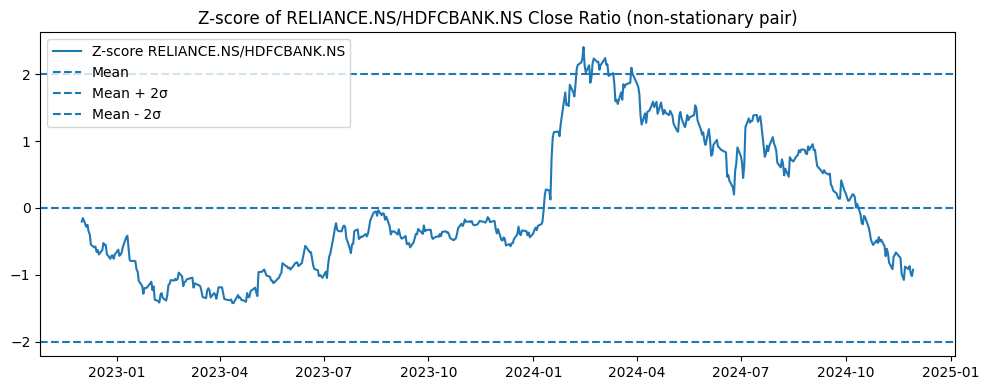

In [5]:
# 2B) Z Score Analysis

def plot_zscore_ratio(pair, title_suffix=""):
    if pair is None:
        print("No pair selected.")
        return
    a, b = pair
    # Ensuring we have data
    if a not in close_data:
        df_a = fetch_ohlc(a, STAT_START, STAT_END)
        close_data[a] = pd.to_numeric(df_a["Close"], errors="coerce").dropna() if not df_a.empty else pd.Series(dtype=float)
    if b not in close_data:
        df_b = fetch_ohlc(b, STAT_START, STAT_END)
        close_data[b] = pd.to_numeric(df_b["Close"], errors="coerce").dropna() if not df_b.empty else pd.Series(dtype=float)

    ratio = (close_data[a] / close_data[b]).dropna()
    if ratio.empty:
        print(f"No ratio data for {a}/{b}.")
        return
    z = zscore(ratio)
    m, s = z.mean(), z.std(ddof=0)

    plt.figure(figsize=(10,4))
    plt.plot(z.index, z.values, label=f"Z-score {a}/{b}")
    plt.axhline(m, linestyle="--", label="Mean")
    plt.axhline(m + 2*s, linestyle="--", label="Mean + 2σ")
    plt.axhline(m - 2*s, linestyle="--", label="Mean - 2σ")
    plt.title(f"Z-score of {a}/{b} Close Ratio {title_suffix}".strip())
    plt.legend(); plt.tight_layout(); plt.show()

plot_zscore_ratio(STATIONARY_PAIR, "(stationary pair)")
plot_zscore_ratio(NONSTATIONARY_PAIR, "(non-stationary pair)")


In [7]:
# 2C) Sharpe Ratio

def extract_close_series(df: pd.DataFrame) -> pd.Series:
    """
    Return a 1-D Close price Series from a yfinance DataFrame that may have
    single-level or MultiIndex columns. Returns empty Series if not found.
    """
    if df is None or df.empty:
        return pd.Series(dtype="float64")

    # MultiIndex columns case
    if isinstance(df.columns, pd.MultiIndex):
        # Try (field, ticker) where field == 'Close'
        cand = [col for col in df.columns if str(col[0]).strip().lower() == "close"]
        if cand:
            s = df[cand[0]]
            if isinstance(s, pd.DataFrame) and s.shape[1] > 0:
                s = s.iloc[:, 0]
            return pd.to_numeric(s, errors="coerce").dropna()

        # Try (ticker, field) where field == 'Close'
        cand = [col for col in df.columns if str(col[-1]).strip().lower() == "close"]
        if cand:
            s = df[cand[0]]
            if isinstance(s, pd.DataFrame) and s.shape[1] > 0:
                s = s.iloc[:, 0]
            return pd.to_numeric(s, errors="coerce").dropna()

        # Fallback: flatten and pick first column that startswith 'close'
        flat = df.copy()
        flat.columns = ["_".join(map(str, c)).strip() for c in df.columns]
        for c in flat.columns:
            if str(c).strip().lower().startswith("close"):
                return pd.to_numeric(flat[c], errors="coerce").dropna()
        return pd.Series(dtype="float64")

    # Single-level columns
    col = None
    for c in df.columns:
        name = str(c).strip().lower()
        if name == "close" or name.startswith("close"):
            col = c
            break
    if col is None:
        return pd.Series(dtype="float64")

    s = df[col]
    if isinstance(s, pd.DataFrame) and s.shape[1] > 0:
        s = s.iloc[:, 0]
    return pd.to_numeric(s, errors="coerce").dropna()

# ---- Compute Sharpe for FOCUS_STOCK over SHARPE_START..SHARPE_END ----
df_sr = fetch_ohlc(FOCUS_STOCK, SHARPE_START, SHARPE_END)
if df_sr.empty:
    print(f"No data for {FOCUS_STOCK} in {SHARPE_START}–{SHARPE_END}.")
else:
    close = extract_close_series(df_sr)
    if close.empty:
        print(f"Could not extract a Close series for {FOCUS_STOCK}. Columns: {list(df_sr.columns)}")
    else:
        rets = close.pct_change().dropna()
        if rets.std(ddof=0) == 0:
            print(f"Insufficient volatility to compute Sharpe for {FOCUS_STOCK} in the window.")
        else:
            sharpe = (rets.mean() / rets.std(ddof=0)) * np.sqrt(252)  # RF ~ 0
            print(f"Sharpe ratio (approx, RF~0) for {FOCUS_STOCK} over {SHARPE_START}→{SHARPE_END}: {sharpe:.3f}")


Sharpe ratio (approx, RF~0) for TCS.NS over 2023-12-01→2024-11-30: 1.112


In [10]:
#2D)

def golden_death_cross_dates(close, short: int = 15, long: int = 50):
    """
    Accepts a pandas Series OR DataFrame for 'close'.
    If DataFrame, uses the first column found.
    Returns (golden_cross_dates, death_cross_dates) as lists of Timestamps.
    """
    import pandas as pd

    # If a DataFrame slipped in, pick the first column
    if isinstance(close, pd.DataFrame):
        if close.shape[1] == 0:
            return [], []
        close = close.iloc[:, 0]

    # Now 'close' must be a Series
    c = pd.to_numeric(close, errors="coerce").dropna()
    if c.empty:
        return [], []

    ma_s = c.rolling(short).mean()
    ma_l = c.rolling(long).mean()

    golden = (ma_s.shift(1) < ma_l.shift(1)) & (ma_s >= ma_l)   # short crosses above long
    death  = (ma_s.shift(1) > ma_l.shift(1)) & (ma_s <= ma_l)   # short crosses below long

    return list(c.index[golden.fillna(False)]), list(c.index[death.fillna(False)])


Golden Cross dates for TCS.NS:
   2023-05-15
   2023-07-04
   2023-12-05
   2024-06-27
   2024-11-28

Death Cross dates for TCS.NS:
   2023-03-10
   2023-06-28
   2023-10-31
   2024-04-03
   2024-09-30


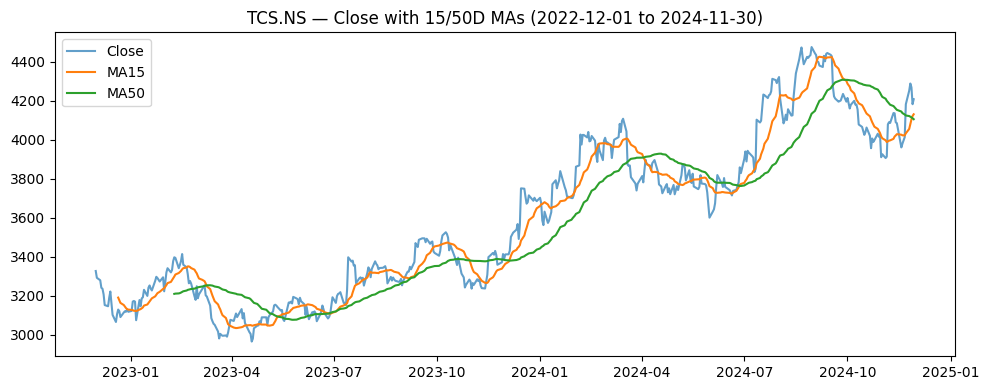

In [11]:
# 2D) Golden Cross & Death Cross (15D vs 50D MAs)
df_gc = fetch_ohlc(FOCUS_STOCK, CROSS_START, CROSS_END)

def _get_close_series(df):
    """Return a 1-D Close series from single- or multi-level columns."""
    import pandas as pd
    if df is None or df.empty:
        return pd.Series(dtype=float)

    cols = df.columns
    # Single-level first
    if not isinstance(cols, pd.MultiIndex):
        # direct or case-insensitive
        if "Close" in df.columns:
            s = df["Close"]
        else:
            cand = [c for c in df.columns if str(c).strip().lower() == "close" or str(c).strip().lower().startswith("close")]
            s = df[cand[0]] if cand else pd.Series(dtype=float)
        # If still DataFrame (edge case), take first column
        return s.iloc[:,0] if isinstance(s, pd.DataFrame) else s

    for lvl0, lvl1 in df.columns:
        if str(lvl0).strip().lower() == "close":
            return pd.to_numeric(df[(lvl0, lvl1)], errors="coerce")
    for lvl0, lvl1 in df.columns:
        if str(lvl1).strip().lower() == "close":
            return pd.to_numeric(df[(lvl0, lvl1)], errors="coerce")

    dff = df.copy()
    dff.columns = ["_".join(map(str, tup)).strip() for tup in df.columns]
    cand = [c for c in dff.columns if c.lower().startswith("close")]
    return pd.to_numeric(dff[cand[0]], errors="coerce") if cand else pd.Series(dtype=float)

if df_gc.empty:
    print(f"No data for {FOCUS_STOCK} in {CROSS_START}–{CROSS_END}.")
else:
    close_series = _get_close_series(df_gc).dropna()
    if close_series.empty:
        print(f"Couldn't extract a Close series for {FOCUS_STOCK}. Columns: {list(df_gc.columns)}")
    else:
        ups, downs = golden_death_cross_dates(close_series, short=15, long=50)
        print(f"Golden Cross dates for {FOCUS_STOCK}:")
        for d in ups: print("  ", pd.to_datetime(d).date())
        print(f"\nDeath Cross dates for {FOCUS_STOCK}:")
        for d in downs: print("  ", pd.to_datetime(d).date())

        # Optional visualization
        c = pd.to_numeric(close_series, errors="coerce").dropna()
        ma15 = c.rolling(15).mean()
        ma50 = c.rolling(50).mean()
        plt.figure(figsize=(10,4))
        plt.plot(c.index, c.values, label="Close", alpha=0.7)
        plt.plot(ma15.index, ma15.values, label="MA15")
        plt.plot(ma50.index, ma50.values, label="MA50")
        plt.title(f"{FOCUS_STOCK} — Close with 15/50D MAs ({CROSS_START} to {CROSS_END})")
        plt.legend(); plt.tight_layout(); plt.show()
